In [2]:
import numpy as np
import pandas as pd

In [3]:
#Scrapping data from wikipedia

import requests
from lxml import html

pageContent=requests.get(
     'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
)
tree = html.fromstring(pageContent.content)
torontoTable = tree.xpath('//*[@id="mw-content-text"]/div/table[1]/tbody//text()')

In [4]:
#continue preprocess wikipedia data with XPATH

counter = 0
torontoArray =[]
torontoItem =""

for data in torontoTable:
    if data.strip() != '' and data.strip() != 'Postal code' and data.strip() != 'Borough' and data.strip() != 'Neighborhood' :
        if counter%3 == 0:
            if data.strip()[0] != 'M':
                continue
            torontoArray.append(torontoItem)
            torontoItem=data.strip()
        elif data.strip() != 'Not assigned':
            torontoItem =   torontoItem.strip() + "|" + data.strip().replace(" /", ",")
        else :
            torontoItem =   torontoItem.strip()  + "|" + data.strip().replace(" /", ",")
            counter = counter +1
        counter = counter +1
       
    
len(torontoArray)

180

In [5]:
#Adding Latitude and Longtitude

import geocoder
torontoList = []

for item in torontoArray:
    if 'Not assigned' in item :
        continue
    else : 
        if item != '' :
            ItemValue = str(item).split("|")
            stringAddress = ItemValue[0] +", Toronto, Ontario"
            coordinates = geocoder.arcgis(stringAddress).latlng
            ItemValue.append(coordinates[0])
            ItemValue.append(coordinates[1])
            torontoList.append(ItemValue) 
            
torontoList         

[['M3A', 'North York', 'Parkwoods', 43.75293455500008, -79.33564142299997],
 ['M4A',
  'North York',
  'Victoria Village',
  43.72810248500008,
  -79.31188987099995],
 ['M5A',
  'Downtown Toronto',
  'Regent Park, Harbourfront',
  43.65096410900003,
  -79.35304116399999],
 ['M6A',
  'North York',
  'Lawrence Manor, Lawrence Heights',
  43.723265465000054,
  -79.45121077799996],
 ['M7A',
  'Downtown Toronto',
  "Queen's Park, Ontario Provincial Government",
  43.66179000000005,
  -79.38938999999993],
 ['M9A',
  'Etobicoke',
  'Islington Avenue',
  43.66748067300006,
  -79.52895286499995],
 ['M1B',
  'Scarborough',
  'Malvern, Rouge',
  43.80862623100006,
  -79.18991284599997],
 ['M3B', 'North York', 'Don Mills', 43.74890000000005, -79.35721999999998],
 ['M4B',
  'East York',
  'Parkview Hill, Woodbine Gardens',
  43.70719267700008,
  -79.31152927299996],
 ['M5B',
  'Downtown Toronto',
  'Garden District, Ryerson',
  43.65749059800004,
  -79.37752923699998],
 ['M6B', 'North York', 'Glenc

In [6]:
#Adding into Pandas Dataframe
df = pd.DataFrame(torontoList, columns =['Postal code', 'Borough','Neighborhood', 'Latitude' , 'Longitude']) 

In [7]:
df.shape

(103, 5)

In [8]:
df.head(12)

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752935,-79.335641
1,M4A,North York,Victoria Village,43.728102,-79.311890
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
5,M9A,Etobicoke,Islington Avenue,43.667481,-79.528953
6,M1B,Scarborough,"Malvern, Rouge",43.808626,-79.189913
7,M3B,North York,Don Mills,43.748900,-79.357220
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.707193,-79.311529
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529


In [9]:
from geopy.geocoders import Nominatim
import folium


address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
DisplayMap_folium = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'],  df['Neighborhood']):
    label = f'neighborhood: {neighborhood}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#000fff',
        fill=True,
        fill_color='#000fff',
        fill_opacity=0.5,
        parse_html=False).add_to(DisplayMap_folium)  
    
DisplayMap_folium

In [10]:


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # foursquare information
        CLIENT_ID = 'ZRQWTNQECIIM0EQ5L5CLXRHT3KLEQONPTNLDXC4EXT1XLMFV' # Foursquare ID
        CLIENT_SECRET = 'WSM3JPMSBRKAC3SKOAVPU3CBXKGUKGUQON3EE5D2LJXAMQFJ' # Foursquare Secret
        VERSION = '20200408'
        RADIUS = 200
        LIMIT = 100   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [74]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [75]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [76]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [120]:
# top 10 common venues in each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
  
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 


# move neighborhood column to the first column
col_list = list(toronto_onehot.columns)
col_list.remove('Neighborhood')
cols = ['Neighborhood'] + [col for col in col_list]

toronto_onehot = toronto_onehot[cols]
toronto_onehot.head()

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Breakfast Spot,Sushi Restaurant,Badminton Court,Skating Rink,Supermarket
1,"Alderwood, Long Branch",Pizza Place,Athletics & Sports,Gas Station,Coffee Shop,Dance Studio
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Diner,Sandwich Place
3,Bayview Village,Construction & Landscaping,Trail,Flower Shop,Electronics Store,Elementary School
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Sushi Restaurant,Italian Restaurant,Comfort Food Restaurant


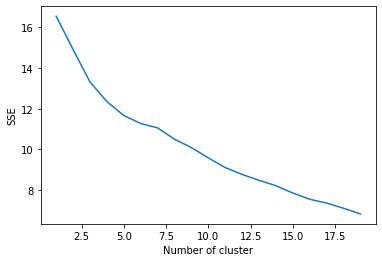

In [121]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Set number of clusters
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(toronto_grouped_clustering)
    toronto_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_
    
toronto_grouped_clustering
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [122]:
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, max_iter=1000).fit(toronto_grouped_clustering)
toronto_grouped_clustering["clusters"] = kmeans.labels_
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [123]:
toronto_merged = df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(inplace = True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.752935,-79.335641,3,Construction & Landscaping,Food & Drink Shop,Park,Eastern European Restaurant,Food
1,M4A,North York,Victoria Village,43.728102,-79.311890,0,Park,Pizza Place,Portuguese Restaurant,French Restaurant,Coffee Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041,0,Pub,Mediterranean Restaurant,Café,Athletics & Sports,Performing Arts Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211,0,Clothing Store,Furniture / Home Store,Men's Store,Bookstore,Food Court
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390,0,Coffee Shop,Sushi Restaurant,Café,Juice Bar,Bookstore


In [124]:
 # Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


    #Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) + ')', parse_html=True)
    map_clusters.add_child(
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

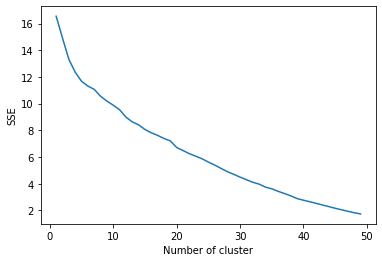